In [5]:
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install scipy

In [11]:
import os
import pandas as pd
import re

# Define the folder containing the CSV files
folder_path = '../Data/SyntheticData'

# Initialize an empty list to store each CSV DataFrame
df_list = []

# Get all CSV filenames in the folder
filenames = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Sort filenames based on the numeric part (assuming they are in the format user0.csv, user1.csv, ..., user99.csv)
filenames_sorted = sorted(filenames, key=lambda x: int(re.search(r'\d+', x).group()))

# Loop through the sorted filenames and assign the Patient ID based on the file name
for filename in filenames_sorted:
    file_path = os.path.join(folder_path, filename)
    
    # Read each CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Extract the file name without the '.csv' extension as the Patient ID
    patient_id = filename.replace('.csv', '')
    
    # Add a new column for the Patient ID
    df['Patient ID'] = patient_id
    
    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Swap the column names in a single rename step
combined_df.rename(columns={
    'Sleep duration_minutes': 'Sleep type duration_minutes',
    'Sleep type duration_minutes': 'Sleep duration_minutes'
}, inplace=True)

# Show the first few rows of the combined DataFrame
print(combined_df.head())

# Save to a new CSV file if needed
combined_df.to_csv('combined_synthetic_data_with_patient_ids.csv', index=False)


           Datetime       Code         Activity_Type  \
0  2022=12-08 14:17        NaN  No Physical Activity   
1  2022=12-08 21:05  LA11836-6               Running   
2  2022=12-08 22:01  LA11836-6               Running   
3  2022=12-08 22:06  LA11836-6               Running   
4  2022=12-08 22:16        NaN  No Physical Activity   

   Heart rate___beats/minute  Calories burned_kcal  Exercise duration_s  \
0                       72.0                   NaN                  NaN   
1                      156.0                  20.0              40851.0   
2                      170.0                  30.0              44878.0   
3                      166.0                  20.0              21497.0   
4                       78.0                   NaN                  NaN   

   Sleep type duration_minutes  Sleep duration_minutes  \
0                          NaN                     NaN   
1                          NaN                     NaN   
2                          NaN        

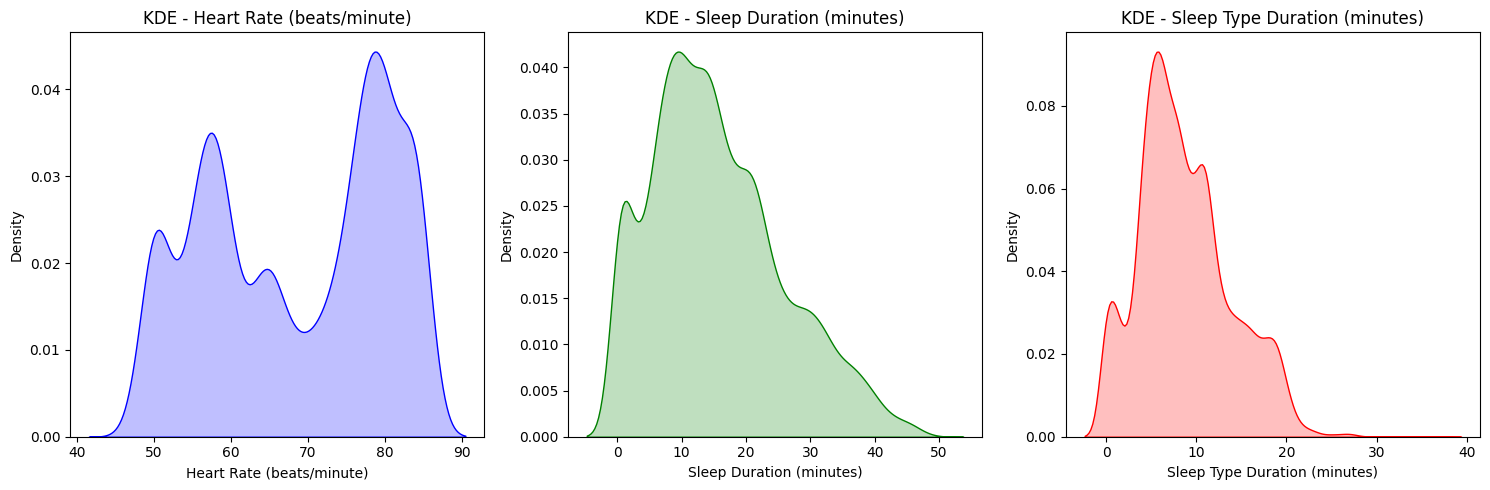

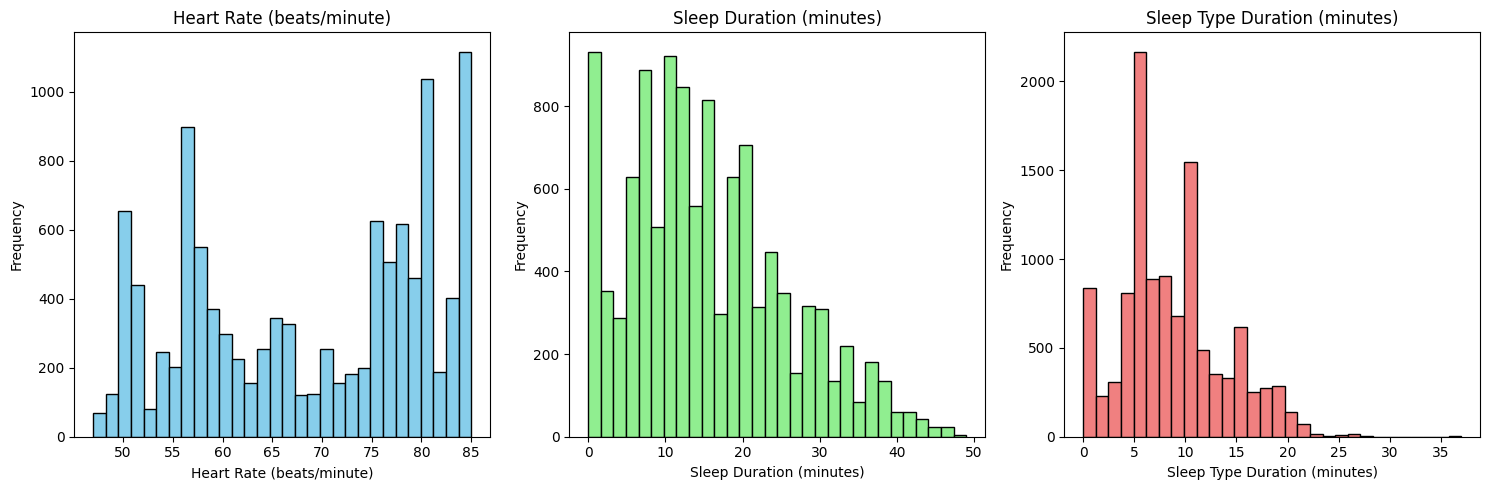

In [12]:
#light sleep analysis 
import matplotlib.pyplot as plt
import seaborn as sns

filtered_df = combined_df[combined_df['Code'] == '93830-8']

# Set up the figure
plt.figure(figsize=(15, 5))

# KDE plot for Heart Rate
plt.subplot(1, 3, 1)
sns.kdeplot(filtered_df['Heart rate___beats/minute'].dropna(), color='blue', fill=True)
plt.title('KDE - Heart Rate (beats/minute)')
plt.xlabel('Heart Rate (beats/minute)')
plt.ylabel('Density')

# KDE plot for Sleep Duration
plt.subplot(1, 3, 2)
sns.kdeplot(filtered_df['Sleep duration_minutes'].dropna(), color='green', fill=True)
plt.title('KDE - Sleep Duration (minutes)')
plt.xlabel('Sleep Duration (minutes)')
plt.ylabel('Density')

# KDE plot for Sleep Type Duration
plt.subplot(1, 3, 3)
sns.kdeplot(filtered_df['Sleep type duration_minutes'].dropna(), color='red', fill=True)
plt.title('KDE - Sleep Type Duration (minutes)')
plt.xlabel('Sleep Type Duration (minutes)')
plt.ylabel('Density')

# Adjust layout
plt.tight_layout()

plt.show()

# Plot distributions for Heart rate, Sleep duration, and Sleep type duration
plt.figure(figsize=(15, 5))

# Heart rate distribution
plt.subplot(1, 3, 1)
plt.hist(filtered_df['Heart rate___beats/minute'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Heart Rate (beats/minute)')
plt.xlabel('Heart Rate (beats/minute)')
plt.ylabel('Frequency')

# Sleep duration distribution
plt.subplot(1, 3, 2)
plt.hist(filtered_df['Sleep duration_minutes'].dropna(), bins=30, color='lightgreen', edgecolor='black')
plt.title('Sleep Duration (minutes)')
plt.xlabel('Sleep Duration (minutes)')
plt.ylabel('Frequency')

# Sleep type duration distribution
plt.subplot(1, 3, 3)
plt.hist(filtered_df['Sleep type duration_minutes'].dropna(), bins=30, color='lightcoral', edgecolor='black')
plt.title('Sleep Type Duration (minutes)')
plt.xlabel('Sleep Type Duration (minutes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()